# ベースライン作成から特徴量エンジニアリングに進む
特徴量エンジニアリングの進め方。
特徴量エンジニアリングは一気に行うのではなく、欠損値の補完、説明変数を生成して追加、バリエーション設計の変更などなどの1つ1つの処理が
モデル精度に与える影響を検証しながら進める。
新しい処理の結果、目指す評価係数が改善されれば採用、悪化すれば不採用にして試行錯誤を繰り返す。
今回はベースラインのコードの以下に変更を加える - 
- データ前処理
- 
- 

今回はタイタニック予測のベースライン作成を行う。
タイタニック予測のは分類問題なので、評価指標はPrecision、Recall、Accuracy、AUC（適合率、再現率、正解率、予測値の順序性）の4つとなる。

# インポート

In [126]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認に使う
# import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理、特徴量作成 - sklearnを使う
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# モデリング・精度と評価指標
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#LGBM
import lightgbm as lgb

#どうでもいい警告は無視する設定に
import warnings
warnings.filterwarnings("ignore")

In [127]:
# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [128]:
df_train = pd.read_csv("titanic_datasets/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## データ確認
データ数、カラム数、データ型を確認する

In [129]:
print("データ形状：")
print(df_train.shape)

print("データ数：")
print(len(df_train))

print("データのコラム数")
print(len(df_train.columns))

データ形状：
(891, 12)
データ数：
891
データのコラム数
12


In [130]:
print("データ型一覧")
df_train.info()

データ型一覧
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# データ前処理
量的・質的変数や度数の一括確認

In [131]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [132]:
#質的変数
df_train.describe(exclude="number").T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


In [133]:
#1つの量的変数の要約統計量を確認する
df_train[["Fare"]].agg(["mean","std","min","max"]).T

,mean,std,min,max
Fare,32.204208,49.693429,0.0,512.3292


In [134]:
#テーブル全体の要約統計量
df_train.agg(["mean","std","min","max"]).T

,mean,std,min,max
PassengerId,446.0,257.353842,1.0,891.0
Survived,0.383838,0.486592,0.0,1.0
Pclass,2.308642,0.836071,1.0,3.0
Name,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Sex,NaN,NaN,female,male
Age,29.699118,14.526497,0.42,80.0
SibSp,0.523008,1.102743,0.0,8.0
Parch,0.381594,0.806057,0.0,6.0
Ticket,NaN,NaN,110152,WE/P 5735
Fare,32.204208,49.693429,0.0,512.3292


pdp.profileReport(df_train)

## 欠損値の補完
欠損している値に本来の値に近いものを当てはめるとより精度が向上する

In [135]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age、Cabin、Embarkedに欠損があるのでその補完を目指す

# 欠損値補完(デモ)
主に欠損値は量的データの場合0, 平均値で、質的データの場合最頻値で補完する。
どの補完方法が最適かは要検証。

In [136]:
"""
# 欠損値を補完した新しい行を作成する
# 0で補完
df_train["Age_fillna_0"] = df_train["Age"].fillna(0)
df_train.loc[df_train["Age"].isnull(), ["Age","Age_fillna_0"]]
"""

'\n# 欠損値を補完した新しい行を作成する\n# 0で補完\ndf_train["Age_fillna_0"] = df_train["Age"].fillna(0)\ndf_train.loc[df_train["Age"].isnull(), ["Age","Age_fillna_0"]]\n'

In [137]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [138]:
"""
# 平均値で補完
age_mean = df_train["Age"].mean()

print("Ageの平均値：")
print(age_mean)

df_train["Age_fillna_mean"] = df_train["Age"].fillna(age_mean)
df_train.loc[df_train["Age"].isnull(), ["Age","Age_fillna_mean"]]
"""

'\n# 平均値で補完\nage_mean = df_train["Age"].mean()\n\nprint("Ageの平均値：")\nprint(age_mean)\n\ndf_train["Age_fillna_mean"] = df_train["Age"].fillna(age_mean)\ndf_train.loc[df_train["Age"].isnull(), ["Age","Age_fillna_mean"]]\n'

In [139]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [140]:
cabin_mode = df_train["Cabin"].mode()[0]

In [141]:
"""
# 最頻値で補完（質的データの場合）
cabin_mode = df_train["Cabin"].mode()[0]

print("Cabinの平均値：")
print(cabin_mode)

df_train["Cabin_fillna_mode"] = df_train["Cabin"].fillna(cabin_mode)
df_train.loc[df_train["Cabin"].isnull(), ["Cabin","Cabin_fillna_mode"]]
"""

'\n# 最頻値で補完（質的データの場合）\ncabin_mode = df_train["Cabin"].mode()[0]\n\nprint("Cabinの平均値：")\nprint(cabin_mode)\n\ndf_train["Cabin_fillna_mode"] = df_train["Cabin"].fillna(cabin_mode)\ndf_train.loc[df_train["Cabin"].isnull(), ["Cabin","Cabin_fillna_mode"]]\n'

# 外れ値の修正・補完
値の分布・平均からの偏差などを可視化して外れ値による精度低下を防ぐ方法を考える。
今回はAgeなどに外れ値がないかを確認する

In [142]:
age_max = df_train["Age"].max()
age_min = df_train["Age"].min()

print("最小値:" + str(age_min))
print("最大値:" + str(age_max))

最小値:0.42
最大値:80.0


<Axes: >

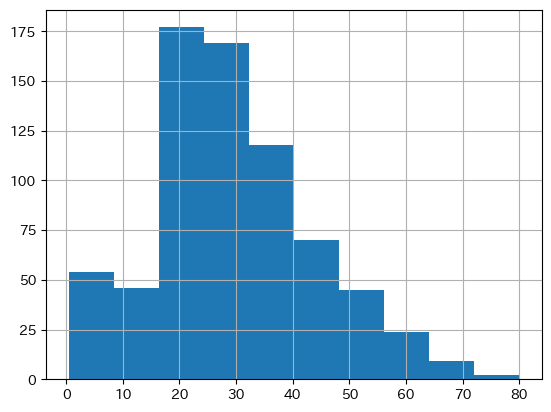

In [143]:
df_train["Age"].hist()

値が正規分布に近い場合、4分位範囲に1.5倍を掛けた値以上を外れ値とし、それらを最小値・最小値で補完するという方法が考えられる。
4分位範囲はpandasのseries型に.quantileを適用することで算出できる

回帰予測のモデルを作る際過去に有効だった方法として、平均から標準偏差のn倍以上・以下の偏差のある値を外れ値とし平均＋標準偏差のn倍で補完する
という手法がある。標準偏差の2倍以上の差がある場合は約5%、3倍以上の差がある場合は約0.3%のデータを除外することになる。

In [144]:
"""
quartile_area = df_train["Age"].quantile(q=0.75) - df_train["Age"].quantile(q=0.25)
print("4分位範囲の値: " + str(quartile_area))
"""

'\nquartile_area = df_train["Age"].quantile(q=0.75) - df_train["Age"].quantile(q=0.25)\nprint("4分位範囲の値: " + str(quartile_area))\n'

In [145]:
"""
normal_min = df_train["Age"].quantile(q=0.25) - quartile_area*1.5
normal_max = df_train["Age"].quantile(q=0.75) + quartile_area*1.5

print("正常値の下限 " + str(normal_min))
print("正常値の上限 " + str(normal_max))
"""


'\nnormal_min = df_train["Age"].quantile(q=0.25) - quartile_area*1.5\nnormal_max = df_train["Age"].quantile(q=0.75) + quartile_area*1.5\n\nprint("正常値の下限 " + str(normal_min))\nprint("正常値の上限 " + str(normal_max))\n'

4分位範囲の1.5倍を除外する手法だと、年齢として正常値である65歳以上の値も除外されてしまう。
外れ値の除外に使う数式やアルゴリズムは柔軟に使い分ける必要がある。
今回は正常値の下限を下回る値のみを0に置換するコードだけを実装する

In [146]:
"""
df_train.loc[df_train["Age"]<normal_min, "Age"] = 0
"""

'\ndf_train.loc[df_train["Age"]<normal_min, "Age"] = 0\n'

In [147]:
"""
age_std = df_train["Age"].std()
age_mean = df_train["Age"].mean()

normal_min = age_mean - age_std*3
normal_max = age_mean + age_std*3

print("正常値の下限 " + str(normal_min))
print("正常値の上限 " + str(normal_max))
"""

'\nage_std = df_train["Age"].std()\nage_mean = df_train["Age"].mean()\n\nnormal_min = age_mean - age_std*3\nnormal_max = age_mean + age_std*3\n\nprint("正常値の下限 " + str(normal_min))\nprint("正常値の上限 " + str(normal_max))\n'

→今回は4分位範囲・標準偏差のn倍による補完は行なわない

# 標準化・正規化
モデルによっては量的データを標準化(平均0・標準偏差1に変換)・正規化(最小値0・最大値1に変換)すると精度が向上する。
モデルによってはこれらの値を処理しないとモデルに適した値とならないケースもある。
- 標準化が必要 → 重回帰アルゴリズム、K近傍法、ニューラルネット、深層学習
- 正規化が必要 → ニューラルネット、深層学習

LightGBMのような決定木モデルでは標準化・正規化は不要だが、場合によりけりなので要検証。
今回は仮に運賃(Fare)をsklearnの機能で標準化・正規化する。

In [148]:
"""
#標準化
from sklearn.preprocessing import StandardScaler

# 標準化用のクラスのインスタンス
std = StandardScaler()
std.fit(df_train[["Fare"]])

print("Fareの平均値：", std.mean_[0])
print("Fareの分散：", std.var_[0])
fare_std = np.sqrt(std.var_[0])
print("Fareの標準偏差：", fare_std)

df_train["Fare_standardized"] = std.transform(df_train[["Fare"]])
df_train[["Fare","Fare_standardized"]].head(10)
"""

'\n#標準化\nfrom sklearn.preprocessing import StandardScaler\n\n# 標準化用のクラスのインスタンス\nstd = StandardScaler()\nstd.fit(df_train[["Fare"]])\n\nprint("Fareの平均値：", std.mean_[0])\nprint("Fareの分散：", std.var_[0])\nfare_std = np.sqrt(std.var_[0])\nprint("Fareの標準偏差：", fare_std)\n\ndf_train["Fare_standardized"] = std.transform(df_train[["Fare"]])\ndf_train[["Fare","Fare_standardized"]].head(10)\n'

In [149]:
"""
#正規化
from sklearn.preprocessing import MinMaxScaler

# 標準化用のクラスのインスタンス
minmax = MinMaxScaler()
minmax.fit(df_train[["Fare"]])

print("Fareの最小値：", df_train["Fare"].min())
print("Fareの最大値：", df_train["Fare"].max())

df_train["Fare_0-1"] = minmax.transform(df_train[["Fare"]])
df_train[["Fare","Fare_0-1"]].head(10)
"""

'\n#正規化\nfrom sklearn.preprocessing import MinMaxScaler\n\n# 標準化用のクラスのインスタンス\nminmax = MinMaxScaler()\nminmax.fit(df_train[["Fare"]])\n\nprint("Fareの最小値：", df_train["Fare"].min())\nprint("Fareの最大値：", df_train["Fare"].max())\n\ndf_train["Fare_0-1"] = minmax.transform(df_train[["Fare"]])\ndf_train[["Fare","Fare_0-1"]].head(10)\n'

# 特徴量生成
生データから新しく説明変数として有力なデータを作成することを、特徴量生成と呼ぶ。
特徴量生成は「タイタニックでは子供が優先して救助されていたので、子供かどうかを年齢から抽出しよう」といった仮説ベースの手法、仮説ベースを用いず説明変数を四則演算する等の機械的手法の大きく2つがある。
どのような特徴量生成が有効かは仮説を立てるデータの知識・物事の本質を見極めるドメイン知識の双方が必要となる。

特徴量生成の手法

- 単変数(量的変数)
対数変換、累乗・指数・逆数変換、離散化、欠損か否かをワンホットエンコーディング

- 単変数(質的変数)
ワンホットエンコーディング、カウントエンコーディング、ラベルエンコーディング、欠損か否かをワンホットエンコーディング

- 2変数組み合わせ
数値×数値の四則演算、質的変数×質的変数のワンホットエンコーディング、数値×質的変数で集約値を算出

- 時系列データ
ラグ特徴量、ウィンドウ特徴量、累積特徴量

- 自然言語
テキストのベクトルとその意味を抽出(BoW、TF-IDF、Word2Vec, BERT)

分析に本質的に役立つ特徴量を抽出するには、適した値を選択する特徴量選択を行う必要がある。
- フィルター法
特徴量・目的変数の相関で有効性の有無を判定
- ラッパー法
特徴量でモデルを学習、精度向上するか否かで判定
- 組み込み法
モデル学習時に特徴量の選択を行う。Lasso回帰は組み込み法を用いて有用でない特徴量のウェイトを下げる。

タイタニックレベルのテーブルデータでおすすめなのが、ラッパー法。
今回は前回制作したタイタニック予測で有効だった特徴量エンジニアリングに加えてラッパー法による精度向上を目指す。

今回の特徴量エンジニアリング：

Parch・SibspをまとめてFamilySizeを算出→alone, small, medium, bigなどの質的変数にする
同じチケットを持っている乗客数を特徴量(量化)にする
Nameの敬称を特徴量にする。性別、既婚者、成人か否かを学習に使える
運賃Fareをビニングする。仮に5の質的変数にする
客室Classの頭文字を特徴量にする。客室の位置・等級などを特徴量にできる

In [150]:
#性別(sex)→0,1
# 古典的な男女の質的変数など、ダミー化した情報が1つで十分な場合は多重共線性対策で1つのみ情報を残す
df_train = pd.get_dummies(df_train, columns = ["Sex"], drop_first=True)

In [151]:
#出港地(Embarked)→0,1,2、不明の値は仮にS=0にする
df_train['Embarked'].fillna(('S'), inplace=True)
df_train = pd.get_dummies(df_train, columns = ["Embarked"])

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Fare_0.0,Fare_1.0,Fare_2.0,Fare_3.0,Fare_4.0
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,0,1,1,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,1,0,0,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1,1,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,1,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,0,1,1,0,0,0,0


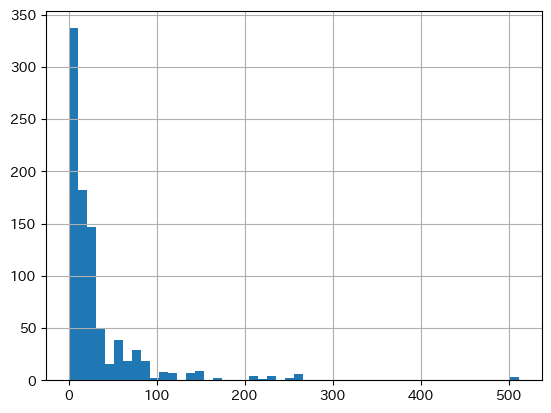

In [152]:
#運賃(Fare)→欠損値は平均値にする
df_train['Fare'].fillna(np.mean(df_train['Fare']), inplace=True)
#運賃(Fare)のヒストグラムを描写。ポアソン分布となる説明変数はビニングすると精度が向上する事が分かっている
df_train['Fare'].hist(bins=50)

# NOTE 境界値を指定したビニング
bins_Fare = [0,50,100,200,300,1000]
# T_Bil列を分割し、0始まりの連番でラベル化した結果をX_cutに格納する
X_cut, bin_indice = pd.cut(df_train["Fare"], bins=bins_Fare, retbins=True, labels=False)
# bin分割した結果をダミー変数化 (prefix=X_Cut.nameは、列名の接頭語を指定している)
X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name)
# 元の説明変数のデータフレーム(X)と、ダミー変数化した結果(X_dummies)を横連結
df_train = pd.concat([df_train, X_dummies], axis=1)

# 結果の確認
df_train.head()

In [153]:
#年齢(Age)→欠損値は平均値・標準偏差を使って正規乱数で埋め合わせる
age_avg = df_train['Age'].mean()
age_std = df_train['Age'].std()

df_train['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)

In [154]:
# 特徴量：Familysizeを作成(Parch, Sibspを足した値)
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp'] + 1 #ALLデータ
# FamilySizeを離散化
df_train['FamilySize_bin'] = 'big'
df_train.loc[df_train['FamilySize']==1,'FamilySize_bin'] = 'alone'
df_train.loc[(df_train['FamilySize']>=2) & (df_train["FamilySize"]<=4),'FamilySize_bin'] = 'small'
df_train.loc[(df_train['FamilySize']>=5) & (df_train["FamilySize"]<=7),'FamilySize_bin'] = 'mediam'

In [155]:
# 特徴量：TicketFreq - Ticket頻度をチケットを表す量的変数とする
df_train.loc[:, 'TicketFreq'] = df_train.groupby(['Ticket'])['PassengerId'].transform('count')


In [156]:
# 特徴量：HonorificをNameから抽出
df_train['honorific'] = df_train['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df_train['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
df_train['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
df_train['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

In [157]:
# 特徴量：Cabin_ini - Cabinの頭文字を抽出
df_train['Cabin_ini'] = df_train['Cabin'].map(lambda x:str(x)[0])
df_train['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

In [158]:
print("コラム名:")
print(df_train.columns)

print("コラム数:")
print(len(df_train.columns))

# 結果の確認
df_train.head()

コラム名:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Fare_0.0', 'Fare_1.0', 'Fare_2.0', 'Fare_3.0',
       'Fare_4.0', 'FamilySize', 'FamilySize_bin', 'TicketFreq', 'honorific',
       'Cabin_ini'],
      dtype='object')
コラム数:
24


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_0.0,Fare_1.0,Fare_2.0,Fare_3.0,Fare_4.0,FamilySize,FamilySize_bin,TicketFreq,honorific,Cabin_ini
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,2,small,1,Mr,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,2,small,1,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,1,0,0,0,0,1,alone,1,Miss,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,0,1,0,0,0,2,small,2,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,1,0,0,0,0,1,alone,1,Mr,n


# 特徴量選択
今回はRFE（Recursive Feature Elimination、再帰的特徴量削減）というラッパー法の手法で学習に使うべき特徴量を選択する。

In [159]:
df_train = pd.get_dummies(df_train, columns = ["FamilySize_bin", "honorific", "Cabin_ini"])

In [160]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Fare_0.0', 'Fare_1.0', 'Fare_2.0', 'Fare_3.0',
       'Fare_4.0', 'FamilySize', 'TicketFreq', 'FamilySize_bin_alone',
       'FamilySize_bin_big', 'FamilySize_bin_mediam', 'FamilySize_bin_small',
       'honorific_Capt', 'honorific_Don', 'honorific_Jonkheer',
       'honorific_Lady', 'honorific_Major', 'honorific_Master',
       'honorific_Miss', 'honorific_Mme', 'honorific_Mr', 'honorific_Mrs',
       'honorific_Rare', 'honorific_Sir', 'honorific_the Countess',
       'Cabin_ini_A', 'Cabin_ini_B', 'Cabin_ini_C', 'Cabin_ini_D',
       'Cabin_ini_E', 'Cabin_ini_F', 'Cabin_ini_Rare', 'Cabin_ini_n'],
      dtype='object')

In [161]:
df_train.dtypes

PassengerId                 int64
Survived                    int64
Pclass                      int64
Name                       object
Age                       float64
SibSp                       int64
Parch                       int64
Ticket                     object
Fare                      float64
Cabin                      object
Sex_male                    uint8
Embarked_C                  uint8
Embarked_Q                  uint8
Embarked_S                  uint8
Fare_0.0                    uint8
Fare_1.0                    uint8
Fare_2.0                    uint8
Fare_3.0                    uint8
Fare_4.0                    uint8
FamilySize                  int64
TicketFreq                  int64
FamilySize_bin_alone        uint8
FamilySize_bin_big          uint8
FamilySize_bin_mediam       uint8
FamilySize_bin_small        uint8
honorific_Capt              uint8
honorific_Don               uint8
honorific_Jonkheer          uint8
honorific_Lady              uint8
honorific_Majo

In [162]:
len(df_train.columns)

46

In [163]:
target_col = 'Survived'
drop_col = ['PassengerId','Survived', 'Name', 'Fare', 'Ticket', 'Cabin', 'Parch', 'FamilySize', 'SibSp']

y = df_train[target_col]
X = df_train.drop(drop_col , axis=1)

In [164]:
X.dtypes

Pclass                      int64
Age                       float64
Sex_male                    uint8
Embarked_C                  uint8
Embarked_Q                  uint8
Embarked_S                  uint8
Fare_0.0                    uint8
Fare_1.0                    uint8
Fare_2.0                    uint8
Fare_3.0                    uint8
Fare_4.0                    uint8
TicketFreq                  int64
FamilySize_bin_alone        uint8
FamilySize_bin_big          uint8
FamilySize_bin_mediam       uint8
FamilySize_bin_small        uint8
honorific_Capt              uint8
honorific_Don               uint8
honorific_Jonkheer          uint8
honorific_Lady              uint8
honorific_Major             uint8
honorific_Master            uint8
honorific_Miss              uint8
honorific_Mme               uint8
honorific_Mr                uint8
honorific_Mrs               uint8
honorific_Rare              uint8
honorific_Sir               uint8
honorific_the Countess      uint8
Cabin_ini_A   

In [165]:
# ここまで実行

In [166]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# estimatorとしてGBDTを使用。特徴量を20個選択
selector = RFE(GradientBoostingRegressor(n_estimators=100, random_state=10), n_features_to_select=20)
selector.fit(X, y)
mask = selector.get_support()
#print(X.feature_names)
print(mask)

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X)
print("X.shape={}, X_selected.shape={}".format(X.shape, X_selected.shape))

[ True  True  True  True False  True  True  True False  True  True  True
  True False  True  True False False False False False  True False False
  True  True  True False False False False False  True  True False False
  True]
X.shape=(891, 37), X_selected.shape=(891, 20)


In [167]:
list = []
not_selected = []
columns = X.columns

for i in range(0, len(mask)):
    
    value = mask[i]
    
    if (value == True):
        list.append(columns[i])
    else:
        not_selected.append(columns[i])

print("選択された20の特徴量：")
print(list)

print("選択されなかった特徴量：")
print(not_selected)

選択された20の特徴量：
['Pclass', 'Age', 'Sex_male', 'Embarked_C', 'Embarked_S', 'Fare_0.0', 'Fare_1.0', 'Fare_3.0', 'Fare_4.0', 'TicketFreq', 'FamilySize_bin_alone', 'FamilySize_bin_mediam', 'FamilySize_bin_small', 'honorific_Master', 'honorific_Mr', 'honorific_Mrs', 'honorific_Rare', 'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_n']
選択されなかった特徴量：
['Embarked_Q', 'Fare_2.0', 'FamilySize_bin_big', 'honorific_Capt', 'honorific_Don', 'honorific_Jonkheer', 'honorific_Lady', 'honorific_Major', 'honorific_Miss', 'honorific_Mme', 'honorific_Sir', 'honorific_the Countess', 'Cabin_ini_A', 'Cabin_ini_B', 'Cabin_ini_C', 'Cabin_ini_F', 'Cabin_ini_Rare']


In [168]:
X_selected

array([[ 3., 22.,  1., ...,  0.,  0.,  1.],
       [ 1., 38.,  0., ...,  0.,  0.,  0.],
       [ 3., 26.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 3., 29.,  0., ...,  0.,  0.,  1.],
       [ 1., 26.,  1., ...,  0.,  0.,  0.],
       [ 3., 32.,  1., ...,  0.,  0.,  1.]])

# ベースライン作成
まず量的データのみを使ったベースラインモデルを作成する

In [169]:
X_train, y_train, id_train = X[list], df_train[["Survived"]], df_train[["PassengerId"]]
X_train.head()

,Pclass,Age,Sex_male,Embarked_C,Embarked_S,Fare_0.0,Fare_1.0,Fare_3.0,Fare_4.0,TicketFreq,FamilySize_bin_alone,FamilySize_bin_mediam,FamilySize_bin_small,honorific_Master,honorific_Mr,honorific_Mrs,honorific_Rare,Cabin_ini_D,Cabin_ini_E,Cabin_ini_n
0,3,22.0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1
1,1,38.0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,3,26.0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
3,1,35.0,0,0,1,0,1,0,0,2,0,0,1,0,0,1,0,0,0,0
4,3,35.0,1,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1


In [170]:
y_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [171]:
# データ形状が問題ないか判定
print(X_train.shape)
print(y_train.shape)
print(id_train.shape)

(891, 20)
(891, 1)
(891, 1)


## ホールドアウト検証
学習用・テスト用の分割を1通り決める

In [172]:
# ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

学習用・訓練用データの形状：
(712, 20)
(712, 1)
(179, 20)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


## 交差検証
学習用・テスト用の分割をテスト用の割合の逆数分だけ繰り返す。偏ったデータによる過学習を防止できる利点があるが、その分学習に時間がかかる。

In [173]:
"""
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))

for nfold in np.arrange(n_splits):
    # 分割分だけデータセットを作成する
    print("-"*20, nfold, "-"*20)
    
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(X_tr.shape, y_tr.shape)
    print(X_va.shape, y_va.shape)
    
    # データのラベルに偏りがないか表示
    y_train_mean = y_train["Survived"].mean()
    y_tr_mean = y_tr["Survived"].mean()
    y_va_mean = y_va["Survived"].mean()
    
    print("全体の生存者割合：")
    print(y_train_mean)
    print("学習用フォールドの生存者割合：")
    print(y_tr_mean)
    print("検証用フォールドの生存者割合：")
    print(y_va_mean)
    
    #機械学習はこの段階で開始
"""

'\nn_splits = 5\ncv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))\n\nfor nfold in np.arrange(n_splits):\n    # 分割分だけデータセットを作成する\n    print("-"*20, nfold, "-"*20)\n    \n    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]\n    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]\n    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]\n    print(X_tr.shape, y_tr.shape)\n    print(X_va.shape, y_va.shape)\n    \n    # データのラベルに偏りがないか表示\n    y_train_mean = y_train["Survived"].mean()\n    y_tr_mean = y_tr["Survived"].mean()\n    y_va_mean = y_va["Survived"].mean()\n    \n    print("全体の生存者割合：")\n    print(y_train_mean)\n    print("学習用フォールドの生存者割合：")\n    print(y_tr_mean)\n    print("検証用フォールドの生存者割合：")\n    print(y_va_mean)\n    \n    #機械学習はこの段階で開始\n'

# モデル学習
LightGBMでベースラインモデルを作成。テーブルデータを使った教師あり学習では大抵コレを使う。
- モデルの精度がそれなりに高い
- 処理が高速
- カテゴリ変数を自動で前処理してくれる
- 欠損値を自動で前処理してくれる
- 異常値の影響を受けにくい

In [174]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

(712, 20)
(712, 1)
(179, 20)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


In [175]:
# LGBMのパラメータ
params = {"boosting_type":"gbdt",
          "objective":"binary",
          "metric":"auc",
          "learning_rate":0.1,
          "num_leaves":16,
          "n_estimators":1000,
          "random_state":123,
          "importance_type":"gain",
          "early_stopping_round":100,
          "verbose":10
          }

# LGBMのモデル
model = lgb.LGBMClassifier(**params)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.850120
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.503997
[LightGBM] [Debug] init for col-wise cost 0.000729 seconds, init for row-wise cost 0.000618 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debu

LGBMClassifier(early_stopping_round=100, importance_type='gain', metric='auc',
               n_estimators=1000, num_leaves=16, objective='binary',
               random_state=123, verbose=10)

次にモデルを実際に動かして学習精度・検証精度を出します。検証精度は一応ランダムな予測以上の値が出ていますが、AUC率よりも低くまだまだ改善の余地があります。

In [176]:
# AUC値に加え精度を算出する
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("モデル精度:")
print("学習精度")
print(metric_tr)
print("検証精度")
print(metric_va)

モデル精度:
学習精度
0.8553370786516854
検証精度
0.8324022346368715


# モデル学習 - LazyPredict
次に、LazyPredictでベースラインモデルを作成します。

In [177]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, random_state=1121, verbose=False,predictions=True)
models, predictions = reg.fit(X_tr, X_va, y_tr, y_va) 

print("モデルの精度・評価指標：")
display(models)
print("テストデータの予測値：")
display(predictions)

100%|██████████| 29/29 [00:02<00:00, 13.50it/s]

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.83,0.82,0.82,0.83,0.05
NuSVC,0.82,0.82,0.82,0.82,0.07
XGBClassifier,0.82,0.81,0.81,0.82,0.12
LogisticRegression,0.82,0.81,0.81,0.82,0.03
LinearDiscriminantAnalysis,0.83,0.81,0.81,0.82,0.05
RidgeClassifierCV,0.83,0.81,0.81,0.82,0.06
RidgeClassifier,0.83,0.81,0.81,0.82,0.04
LGBMClassifier,0.81,0.80,0.80,0.81,0.07
LinearSVC,0.81,0.79,0.79,0.81,0.08


テストデータの予測値：


,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,0,1,1,0,1,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
176,0,1,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
177,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


# 混合行列

In [178]:
y_pred=model.predict(X_va)
y_pred[:5]

array([0, 1, 0, 1, 1], dtype=int64)

混合行列：
[[100  20]
 [ 10  49]]


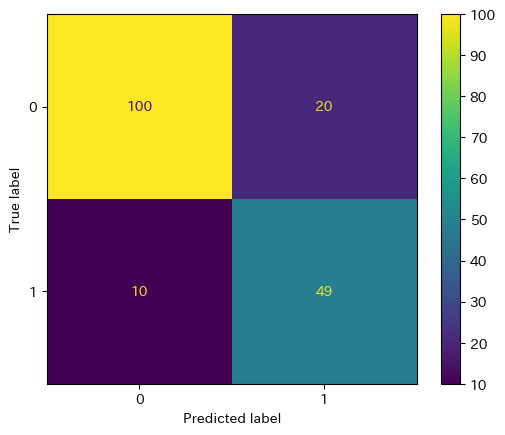

In [179]:
# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
disp.plot()
plt.show()

In [180]:
# 生存できなかった人を正しく予測する率の方が、生存できなかった人を正しく予測する確率よりも高い。(適合率＞再現率)

In [181]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

"""
適合率は予測されたラベルのうち、どれだけが正解だったか
再現率は正解のラベルのうち、どれだけそのラベルを予測できたか

一般的に誤検出を少なくしたい場合には適合率。取りこぼしを少なくしたい場合には再現率を重視します。

医療等に機械学習を活用する等「取りこぼしが多いと命に関わるような重大な問題に繋がる」といったような場合には、再現率を評価指標に使用するのが適切です。
"""

#適合率 - TP+TN / (TP+FP+TN+FN) - 単純な正答率
print("正答率")
print(accuracy_score(y_pred, y_va))

#適合率 - TP / (TP+FP) - 予測されたラベルに対する実際に正解となるサンプル
print("適合率")
print(precision_score(y_pred, y_va))

#再現率 - TP / (TP+FN) - 本来正しく予測した場合に対し実際に正解となるサンプル
print("再現率")
print(recall_score(y_pred, y_va))

print("F値")
print(f1_score(y_pred, y_va))

正答率
0.8324022346368715
適合率
0.7101449275362319
再現率
0.8305084745762712
F値
0.7656250000000001


In [182]:
# 提出用データを作成

In [183]:
df_test = pd.read_csv("titanic_datasets/test.csv")

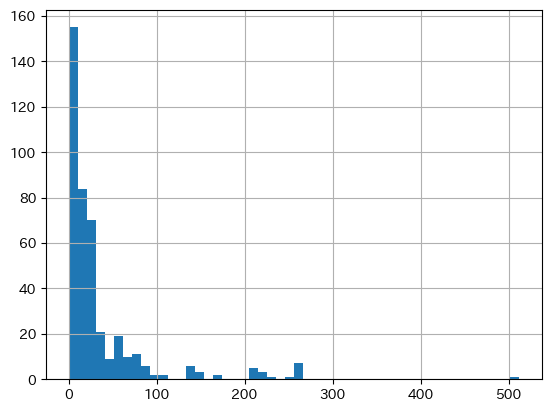

In [184]:
#性別(sex)→0,1
# 古典的な男女の質的変数など、ダミー化した情報が1つで十分な場合は多重共線性対策で1つのみ情報を残す
df_test = pd.get_dummies(df_test, columns = ["Sex"], drop_first=True)

#出港地(Embarked)→0,1,2、不明の値は仮にS=0にする
df_test['Embarked'].fillna(('S'), inplace=True)
df_test = pd.get_dummies(df_test, columns = ["Embarked"])

#運賃(Fare)→欠損値は平均値にする
df_test['Fare'].fillna(np.mean(df_test['Fare']), inplace=True)
#運賃(Fare)のヒストグラムを描写。ポアソン分布となる説明変数はビニングすると精度が向上する事が分かっている
df_test['Fare'].hist(bins=50)

# NOTE 境界値を指定したビニング
bins_Fare = [0,50,100,200,300,1000]
# T_Bil列を分割し、0始まりの連番でラベル化した結果をX_cutに格納する
X_cut, bin_indice = pd.cut(df_test["Fare"], bins=bins_Fare, retbins=True, labels=False)
# bin分割した結果をダミー変数化 (prefix=X_Cut.nameは、列名の接頭語を指定している)
X_dummies = pd.get_dummies(X_cut, prefix=X_cut.name)
# 元の説明変数のデータフレーム(X)と、ダミー変数化した結果(X_dummies)を横連結
df_test = pd.concat([df_test, X_dummies], axis=1)

#年齢(Age)→欠損値は平均値・標準偏差を使って正規乱数で埋め合わせる
age_avg = df_test['Age'].mean()
age_std = df_test['Age'].std()
df_test['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)

# 特徴量：Familysizeを作成(Parch, Sibspを足した値)
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp'] + 1 #ALLデータ
# FamilySizeを離散化
df_test['FamilySize_bin'] = 'big'
df_test.loc[df_test['FamilySize']==1,'FamilySize_bin'] = 'alone'
df_test.loc[(df_test['FamilySize']>=2) & (df_test["FamilySize"]<=4),'FamilySize_bin'] = 'small'
df_test.loc[(df_test['FamilySize']>=5) & (df_test["FamilySize"]<=7),'FamilySize_bin'] = 'mediam'

# 特徴量：TicketFreq - Ticket頻度をチケットを表す量的変数とする
df_test.loc[:, 'TicketFreq'] = df_test.groupby(['Ticket'])['PassengerId'].transform('count')

# 特徴量：HonorificをNameから抽出
df_test['honorific'] = df_test['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df_test['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
df_test['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
df_test['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

# 特徴量：Cabin_ini - Cabinの頭文字を抽出
df_test['Cabin_ini'] = df_test['Cabin'].map(lambda x:str(x)[0])
df_test['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

df_test = pd.get_dummies(df_test, columns = ["FamilySize_bin", "honorific", "Cabin_ini"])

In [185]:
test_feature = df_test[list]

In [186]:
test_feature.columns

Index(['Pclass', 'Age', 'Sex_male', 'Embarked_C', 'Embarked_S', 'Fare_0.0',
       'Fare_1.0', 'Fare_3.0', 'Fare_4.0', 'TicketFreq',
       'FamilySize_bin_alone', 'FamilySize_bin_mediam', 'FamilySize_bin_small',
       'honorific_Master', 'honorific_Mr', 'honorific_Mrs', 'honorific_Rare',
       'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_n'],
      dtype='object')

In [187]:
y_pred = model.predict(test_feature)

# NOTE 予測結果を1次元ベクトルにする
y_pred = np.squeeze(y_pred)
y_pred.shape

(418,)

In [188]:
y_pred[(y_pred >= 0.5)] = 1
y_pred[(y_pred < 0.5)] = 0
y_pred = np.array(y_pred, dtype='int')

y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [189]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
output.to_csv('submission_LGBM_.csv', index=False)

In [190]:
}

SyntaxError: unmatched '}' (70646322.py, line 1)